# Встановлення та імпорт необхідних модулів

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039298 sha256=9b779ee4241db60a9202bb8883f9a646dc1ebbc387ba1d16c5302f03faeab672
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9


In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
import hdbscan


from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.datasets import load_breast_cancer

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import pandas as pd

# Частина 1: Кластеризація
# Огляд датасету та постановка задачі кластеризації

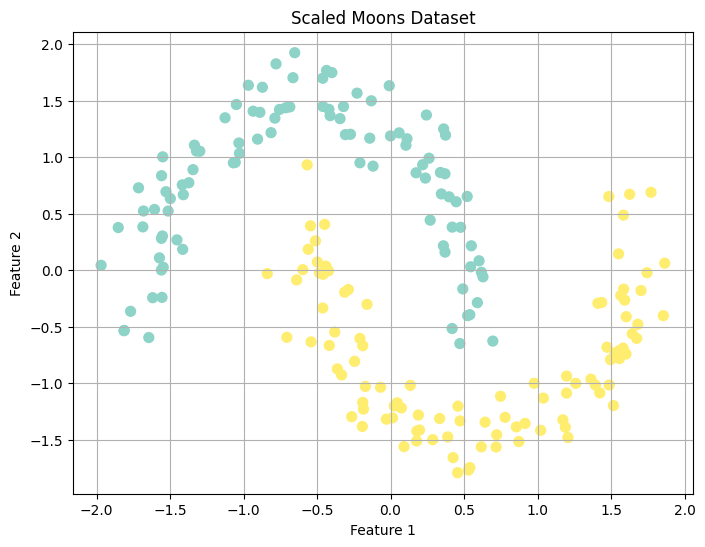

In [ ]:
# Генеруємо датасет у заданих межах
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# Конвертує датасет у DataFrame для полегшення подальших дій
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Target'] = y

# Стандартизуємо дані
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['Feature 1', 'Feature 2']] = scaler.fit_transform(df[['Feature 1', 'Feature 2']])

# Зображуємо датасет на графіку
plt.figure(figsize=(8, 6))
plt.scatter(df_scaled['Feature 1'], df_scaled['Feature 2'], c=df_scaled['Target'], cmap='Set3', s=50)
plt.title('Scaled Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


In [ ]:
df

,Feature 1,Feature 2,Target
0,-1.049426,0.084443,0
1,0.922818,0.457489,0
2,0.656787,0.699597,0
3,1.188940,-0.386528,1
4,0.289265,-0.137745,1
...,...,...,...
195,-0.020120,0.269404,1
196,0.820068,0.375278,0
197,-1.225706,0.288775,0
198,1.844296,-0.101399,1


Наш датасет складається зі зразків, які були сгенеровані з використанням функції `make_moons` від `sklearn.datasets`. Ця функція генерує дані, які формують два переплетені півмісяці, що може бути корисним для випробування алгоритмів кластеризації, особливо для тих, які мають визначити складні форми кластерів.

**Опис датасету**:
- **Кількість зразків**: 200
- **Кількість кластерів**: 2
- **Кількість ознак**: 2 (Feature 1 та Feature 2), що представляють координати точок на площині.
- **Шум**: Додано невелику кількість шуму до даних, щоб створити невеликі варіації та перекриття між кластерами.

**Постановка задачі кластеризації**:
Задача полягає у використанні різних алгоритмів кластеризації для розподілу даних на групи на основі подібності. Завданням є ідентифікація двох півмісяцевидних кластерів та їх розділення один від одного, не дивлячись на наявність шуму та перекриття між ними. Оскільки кластери мають нестандартну форму, це становить особливий виклик для багатьох традиційних методів кластеризації, які передбачають круглу або сферичну форму кластерів.

**Мета кластеризації**:
Визначити оптимальну стратегію та алгоритм кластеризації, який ефективно виявляє та розділяє кластери в цьому складному наборі даних. Враховуючи форму даних, ми прагнемо знайти алгоритм, що здатний адаптуватися до складних форм і щільностей кластерів, забезпечуючи високу якість кластеризації, що може бути оцінена за допомогою метрик, таких як силуетний коефіцієнт, а також візуально через аналіз дендрограм і розподілу точок на графіках.

Серед зазначених методів кластеризації, кількість кластерів можна явно задати у наступних:

1. **K-means** - при ініціалізації моделі необхідно вказати параметр `n_clusters`, який задає кількість кластерів.
2. **Spectral Clustering** - також вимагає вказання кількості кластерів через параметр `n_clusters`.
3. **Hierarchical Clustering** - хоча ієрархічна кластеризація сама по собі не вимагає вказання кількості кластерів під час створення дендрограми, кінцеве розбиття на кластери може бути отримане шляхом "обрізання" дендрограми на певному рівні, що ефективно дозволяє контролювати кількість кластерів.

Методи, де кількість кластерів визначається автоматично або через інші параметри, і не може бути явно задана:

1. **Mean Shift** - кількість кластерів визначається на основі параметра `bandwidth`, який контролює розмір "вікна" пошуку. Кількість кластерів залежить від розподілу даних та розміру вікна.
2. **DBSCAN** - кількість кластерів залежить від параметрів `eps` (максимальна відстань між двома точками для вважання їх в одному кластері) та `min_samples` (мінімальна кількість точок, необхідна для формування кластера).
3. **HDBSCAN** - розширення DBSCAN, яке дозволяє кластеризацію змінної щільності, також не вимагає вказання кількості кластерів і визначає їх на основі щільності даних і параметрів `min_cluster_size` та `min_samples`.

Отже, явно задати кількість кластерів можна в K-means, Spectral Clustering та, з певною мірою гнучкості, у ієрархічній кластеризації.

# K‐mean

In [ ]:
def KMeans_method(n_clusters=2):
  # Застосування кластеризації методом KMeans
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[['Feature 1', 'Feature 2']])

  # Візуалізація результатів кластеризації KMeans
  plt.figure(figsize=(8, 6))
  plt.scatter(df_scaled['Feature 1'], df_scaled['Feature 2'], c=df_scaled['Cluster'], cmap='Set3', s=50)
  plt.title('Кластеризація набору даних Moons методом KMeans')
  plt.xlabel('Ознака 1')
  plt.ylabel('Ознака 2')
  plt.grid(True)

  # Візуалізація центроїдів
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5, marker='X')
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


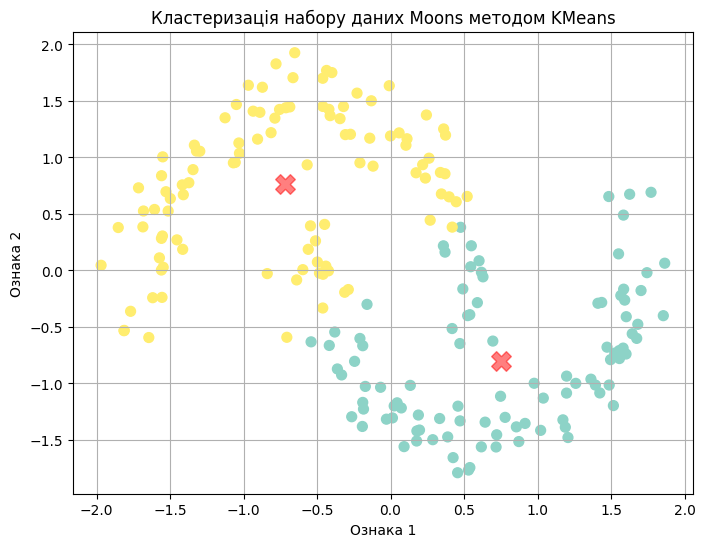

In [ ]:
KMeans_method()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


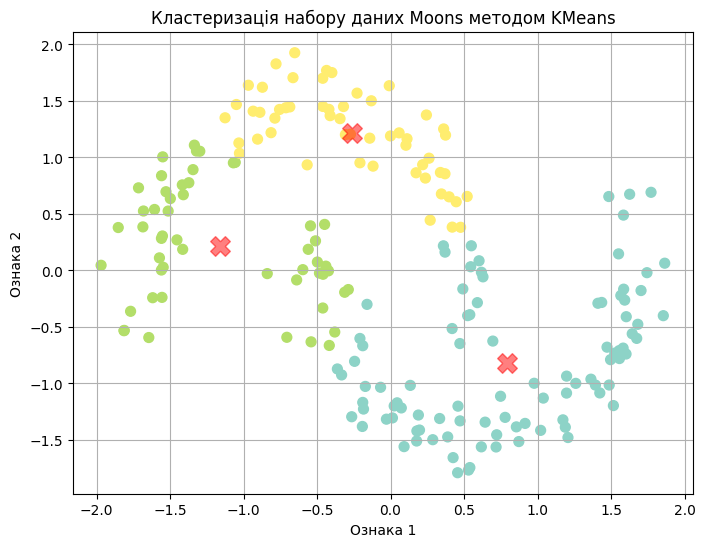

In [ ]:
KMeans_method(3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


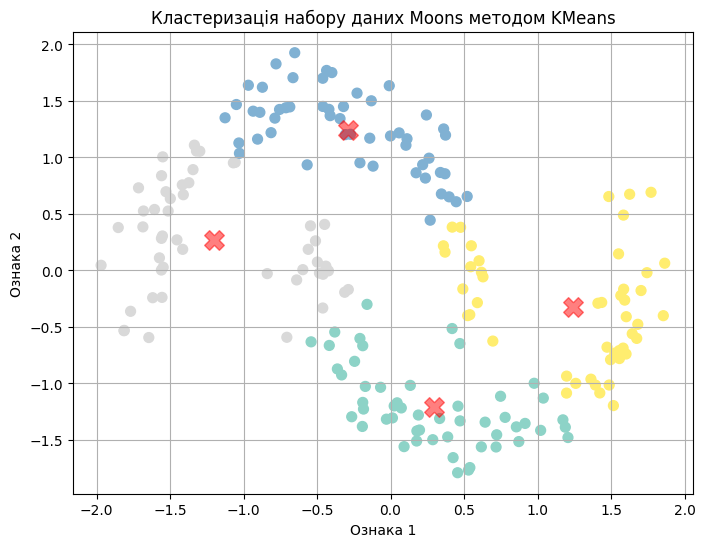

In [ ]:
KMeans_method(4)

# Mean Shift

In [ ]:
def MeanShift_method(quantile=0.3):
  # Оцінка оптимальної ширини смуги для Mean Shift
  bandwidth = estimate_bandwidth(df_scaled[['Feature 1', 'Feature 2']], quantile=quantile)

  # Застосування кластеризації методом Mean Shift
  mean_shift = MeanShift(bandwidth=bandwidth)
  df_scaled['MeanShift_Cluster'] = mean_shift.fit_predict(df_scaled[['Feature 1', 'Feature 2']])

  # Візуалізація результатів кластеризації Mean Shift
  plt.figure(figsize=(8, 6))
  plt.scatter(df_scaled['Feature 1'], df_scaled['Feature 2'], c=df_scaled['MeanShift_Cluster'],  cmap='Set3', s=50)
  plt.title('Кластеризація набору даних Moons методом Mean Shift')
  plt.xlabel('Ознака 1')
  plt.ylabel('Ознака 2')
  plt.grid(True)

  # Візуалізація центроїдів
  centroids = mean_shift.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5, marker='X')
  plt.show()

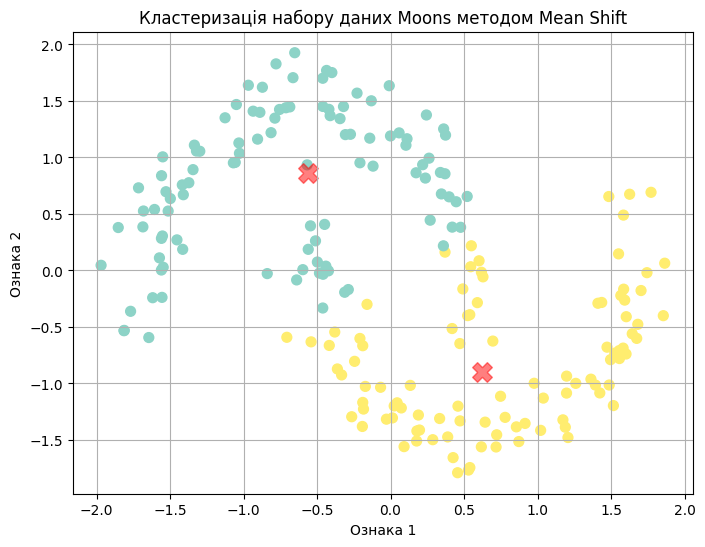

In [ ]:
MeanShift_method(0.3)

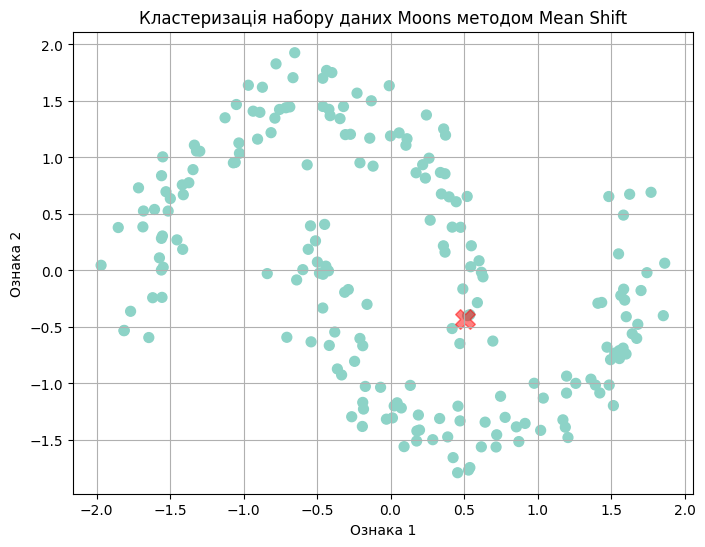

In [ ]:
MeanShift_method(0.5)

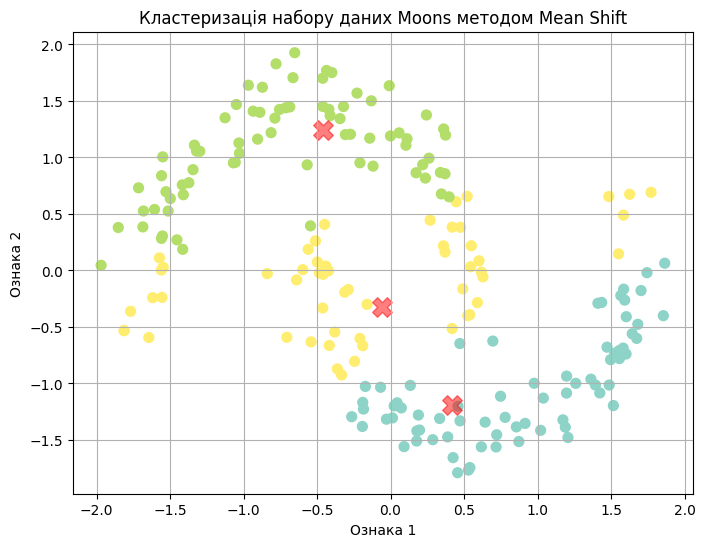

In [ ]:
MeanShift_method(0.2)

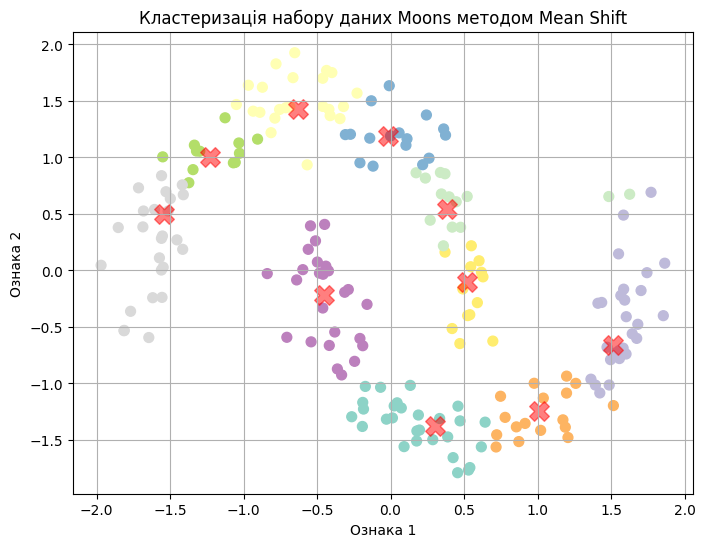

In [ ]:
MeanShift_method(0.1)

# Spectral clustering

In [ ]:
def Spectral_method(n_clusters=2, eigen_solver=None, n_components=None, random_state=42, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol='auto', assign_labels='kmeans'):
  # Застосування кластеризації методом Spectral Clustering
  spectral = SpectralClustering(n_clusters=n_clusters, eigen_solver=eigen_solver, n_components=n_components, random_state=random_state,
                                n_init=10, gamma=gamma, affinity=affinity, n_neighbors=n_neighbors, eigen_tol=eigen_tol, assign_labels=assign_labels)
  df_scaled['Spectral_Cluster'] = spectral.fit_predict(df_scaled[['Feature 1', 'Feature 2']])

  # Візуалізація результатів кластеризації Spectral Clustering
  plt.figure(figsize=(8, 6))
  plt.scatter(df_scaled['Feature 1'], df_scaled['Feature 2'], c=df_scaled['Spectral_Cluster'], cmap='Set3', s=50)
  plt.title('Кластеризація набору даних Moons методом Spectral Clustering')
  plt.xlabel('Ознака 1')
  plt.ylabel('Ознака 2')
  plt.grid(True)
  plt.show()

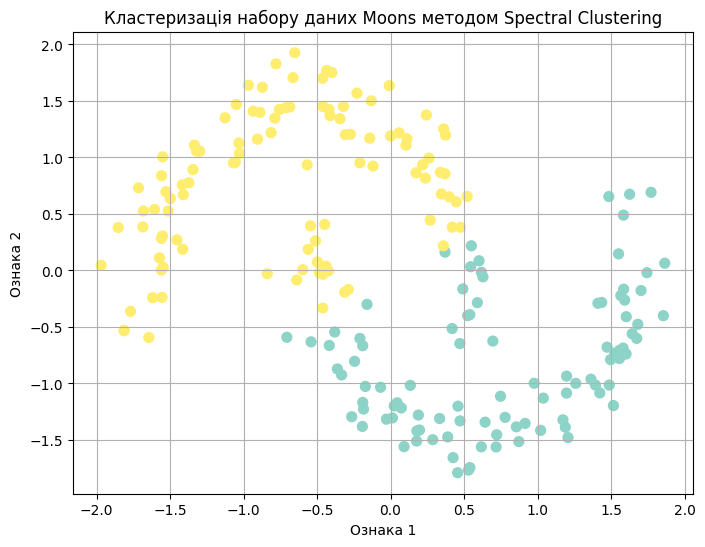

In [ ]:
Spectral_method()

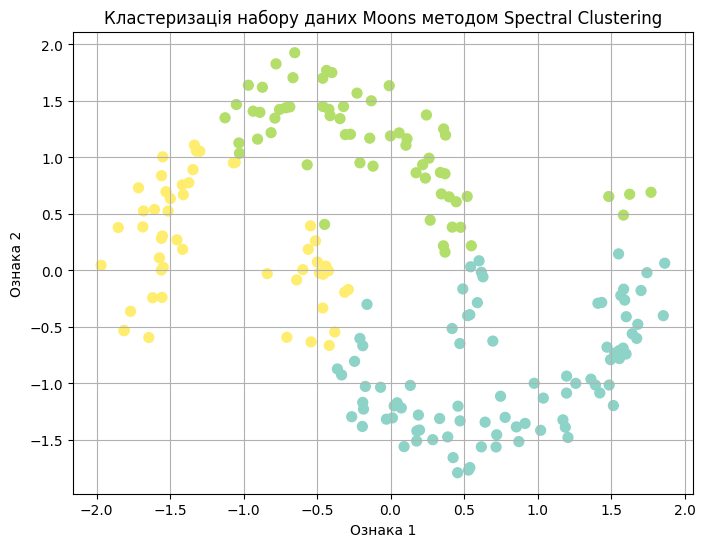

In [ ]:
Spectral_method(n_clusters=3)

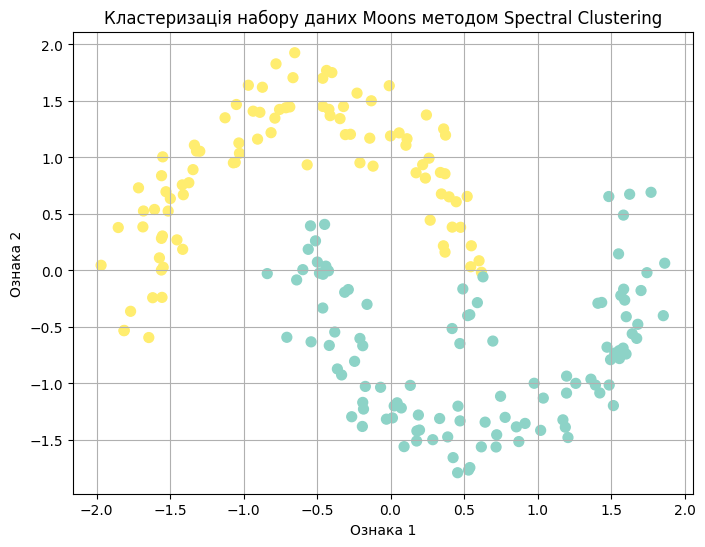

In [ ]:
Spectral_method(eigen_solver='lobpcg', affinity='nearest_neighbors')

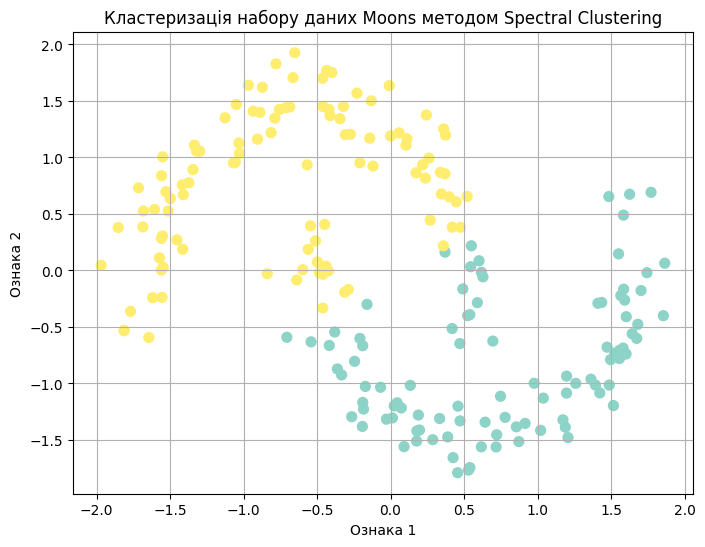

In [ ]:
Spectral_method(assign_labels = 'discretize')

# Hierarchical clustering

In [ ]:
def Linkage_method(method='single'):
  # Застосування ієрархічної кластеризації
  linked = linkage(df_scaled[['Feature 1', 'Feature 2']], method=method)

  # Візуалізація дендрограми
  plt.figure(figsize=(10, 7))
  dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
  plt.title('Дендрограма ієрархічної кластеризації')
  plt.xlabel('Індекс зразка')
  plt.ylabel('Відстань')
  plt.show()

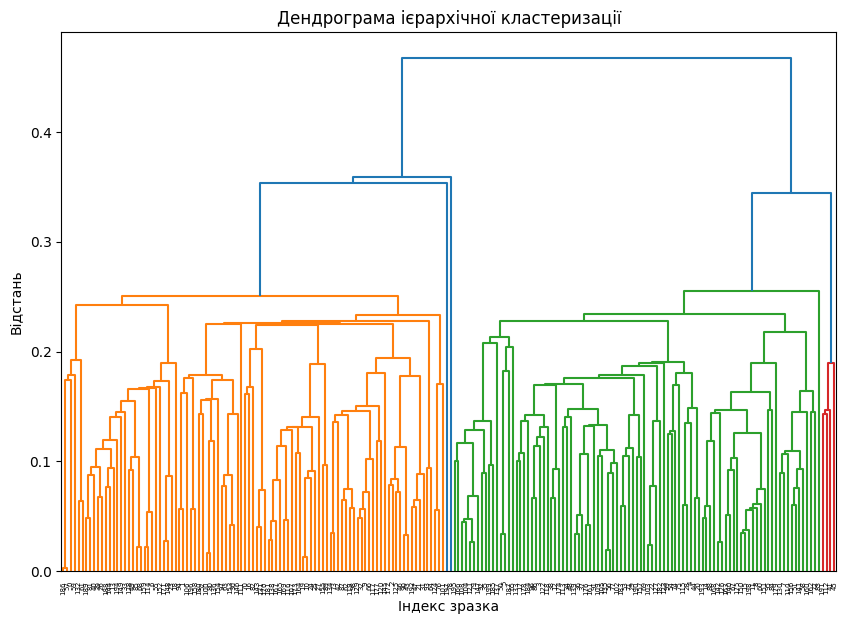

In [ ]:
Linkage_method()

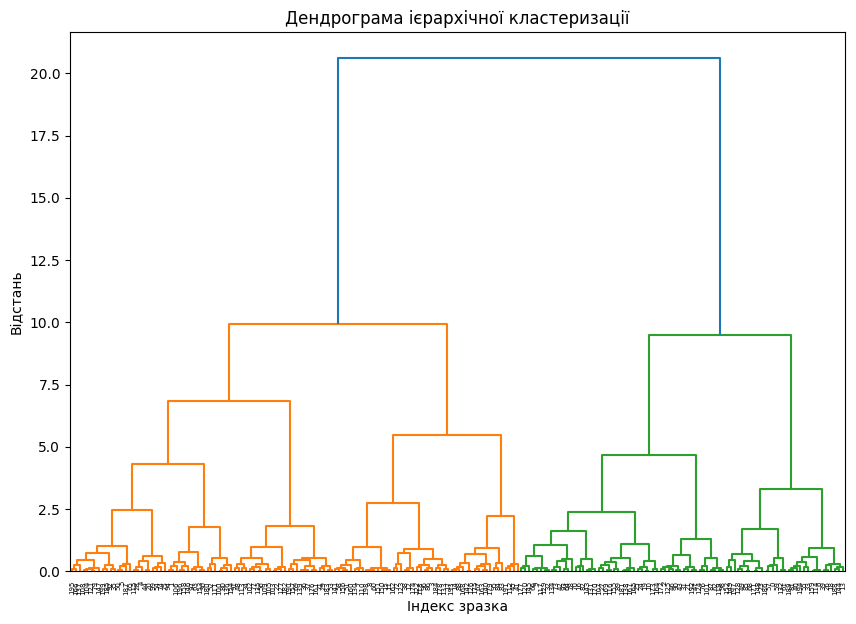

In [ ]:
Linkage_method(method='ward')

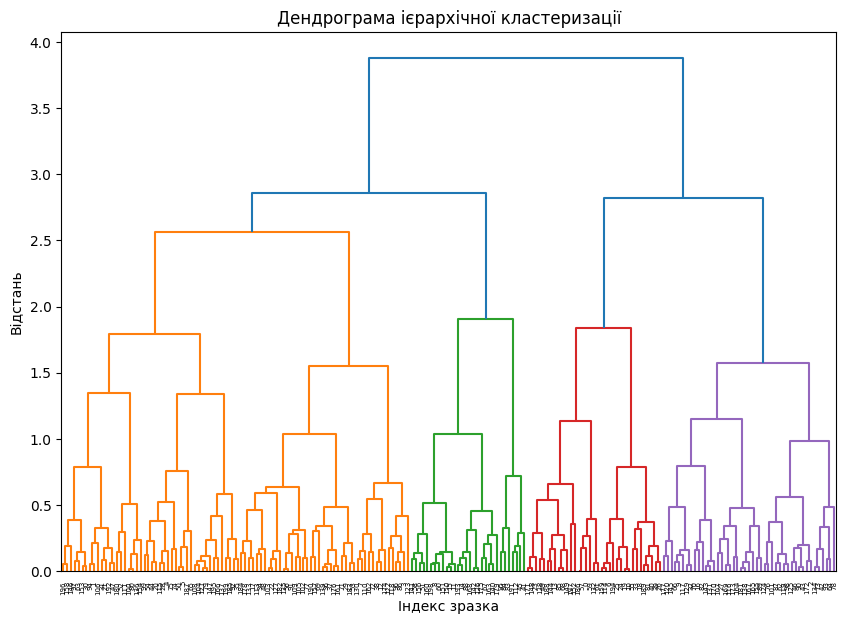

In [ ]:
Linkage_method(method='complete')

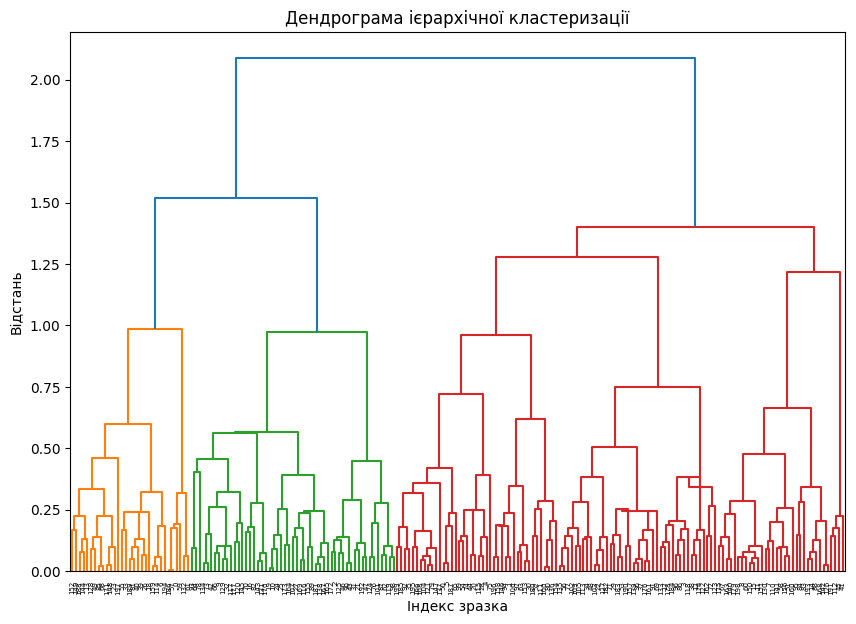

In [ ]:
Linkage_method(method='centroid')

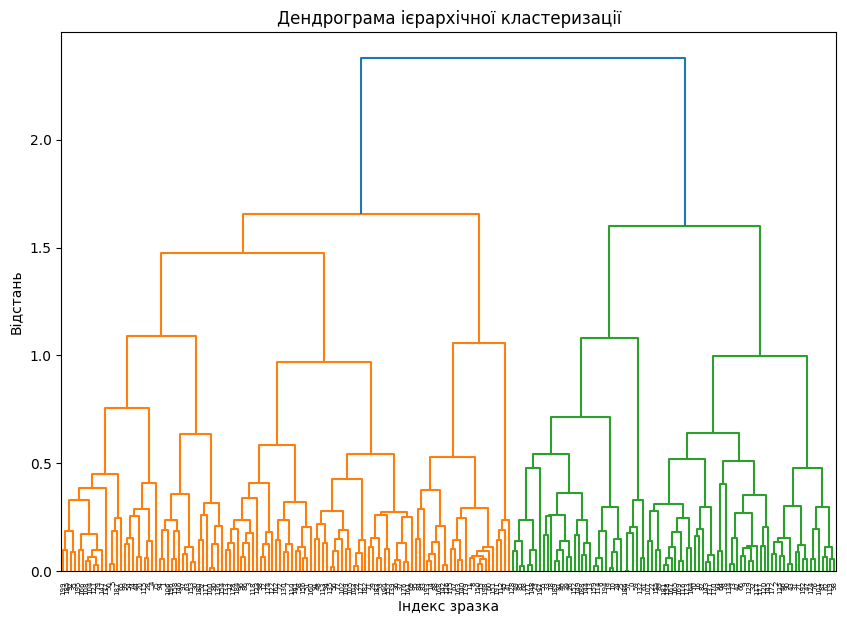

In [ ]:
Linkage_method(method='average')

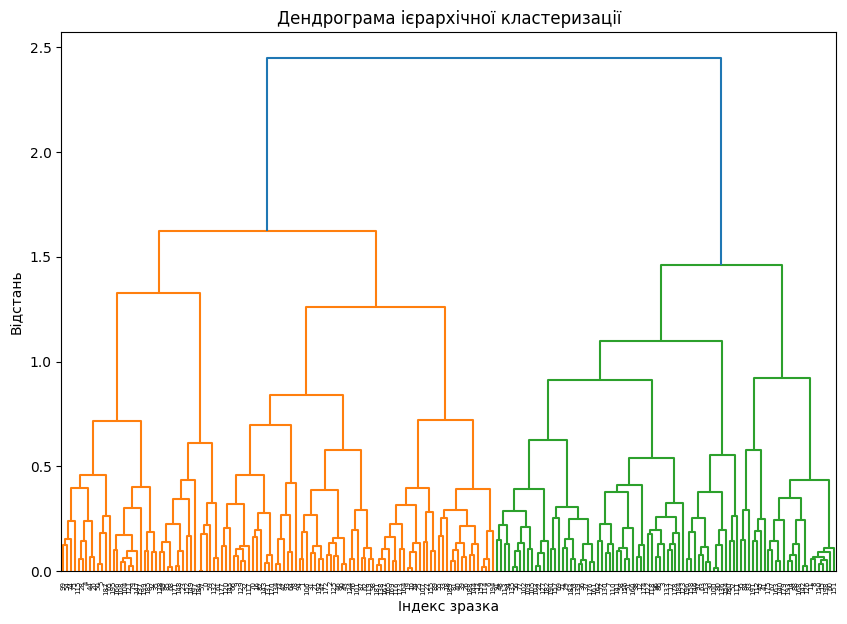

In [ ]:
Linkage_method(method='weighted')

Запишемо мітки класів найкращого відпрацьованого методу для подальшої оцінки

In [ ]:
def Linkage_method_result(df, method='ward', n_clusters=2):
    # Застосування ієрархічної кластеризації
    linked = linkage(df, method=method)

    # Отримання міток кластерів на основі вказаної кількості кластерів
    # 'maxclust' вказує на використання 'n_clusters' як критерію обрізання дендрограми
    labels = fcluster(linked, n_clusters, criterion='maxclust')
    return labels

# Виклик функції і додавання міток кластерів до DataFrame
df_scaled['Hierarchical_Cluster'] = Linkage_method_result(df_scaled[['Feature 1', 'Feature 2']], 'ward', 2)


# DBSCAN

In [ ]:
def DBSCAN_method(eps=0.3, min_samples=5):
  # Застосування кластеризації методом DBSCAN
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  df_scaled['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled[['Feature 1', 'Feature 2']])

  # Візуалізація результатів кластеризації DBSCAN
  plt.figure(figsize=(8, 6))
  plt.scatter(df_scaled['Feature 1'], df_scaled['Feature 2'], c=df_scaled['DBSCAN_Cluster'], cmap='Set3', s=50)
  plt.title('Кластеризація набору даних Moons методом DBSCAN')
  plt.xlabel('Ознака 1')
  plt.ylabel('Ознака 2')
  plt.grid(True)
  plt.show()

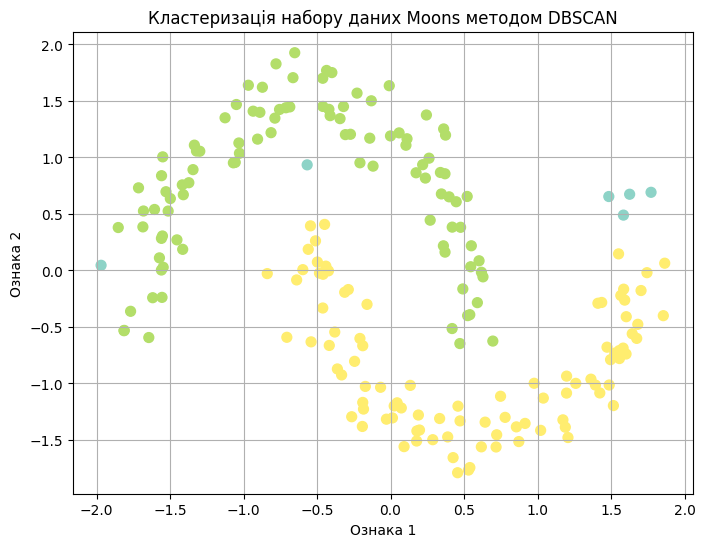

In [ ]:
DBSCAN_method()

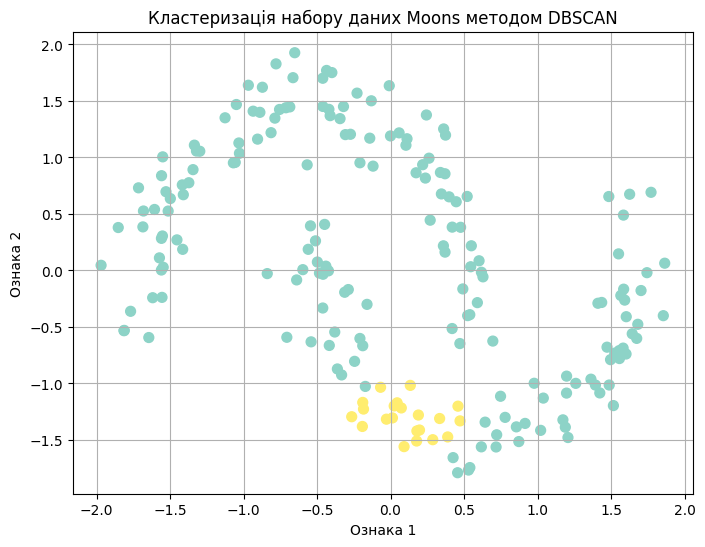

In [ ]:
DBSCAN_method(min_samples=15)

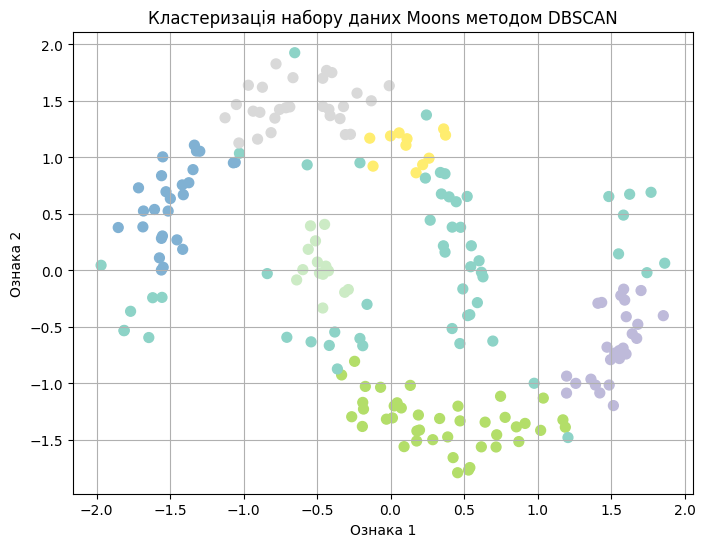

In [ ]:
DBSCAN_method(eps=0.3, min_samples=11)

# HDBSCAN

In [ ]:
def HDBSCAN_method(min_cluster_size=5, min_samples=1):
  # Застосування кластеризації методом HDBSCAN
  hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
  df_scaled['HDBSCAN_Cluster'] = hdbscan_cluster.fit_predict(df_scaled[['Feature 1', 'Feature 2']])

  # Візуалізація результатів кластеризації HDBSCAN
  plt.figure(figsize=(8, 6))
  plt.scatter(df_scaled['Feature 1'], df_scaled['Feature 2'], c=df_scaled['HDBSCAN_Cluster'], cmap='Set3', s=50)
  plt.title('Кластеризація набору даних Moons методом HDBSCAN')
  plt.xlabel('Ознака 1')
  plt.ylabel('Ознака 2')
  plt.grid(True)
  plt.show()

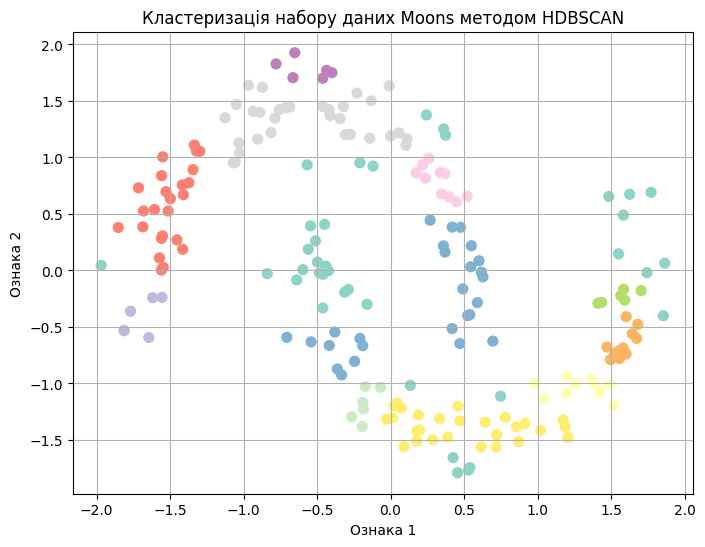

In [ ]:
HDBSCAN_method()

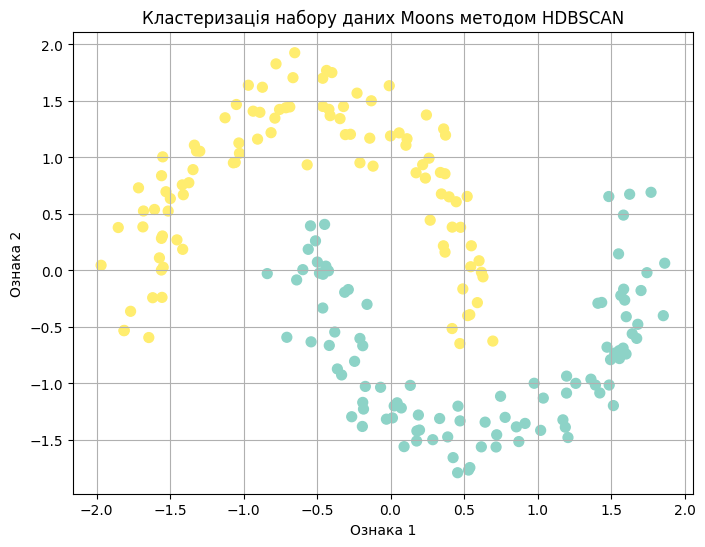

In [ ]:
HDBSCAN_method(min_cluster_size=10, min_samples=1)

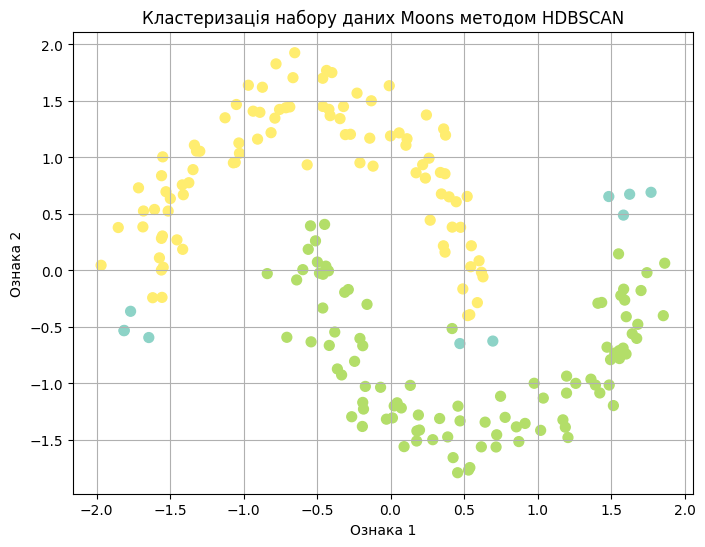

In [ ]:
HDBSCAN_method(min_cluster_size=10, min_samples=10)

# Висновки: Визначення оптимальної кількості кластерів і методу кластеризації

## Силуетний аналіз

Силуетний коефіцієнт — це міра, яка вказує, наскільки добре об'єкт пасує до свого кластера (куогезія) порівняно з іншими кластерами (сепарація). Коефіцієнт близький до +1 вказує на добре відокремлені кластери, наближення до 0 сигналізує про перекривання кластерів, а значення близькі до -1 свідчать про неправильно присвоєні мітки.

In [ ]:
# Вираховуємо силуетні коефіцієнти для різних методів кластеризації
silhouette_scores = {
    'KMeans': silhouette_score(df_scaled[['Feature 1', 'Feature 2']], df_scaled['Cluster']),
    'MeanShift': silhouette_score(df_scaled[['Feature 1', 'Feature 2']], df_scaled['MeanShift_Cluster']),
    'SpectralClustering': silhouette_score(df_scaled[['Feature 1', 'Feature 2']], df_scaled['Spectral_Cluster']),
    'HierarchicalClustering': silhouette_score(df_scaled[['Feature 1', 'Feature 2']], df_scaled['Hierarchical_Cluster']),
    'DBSCAN': silhouette_score(df_scaled[['Feature 1', 'Feature 2']], df_scaled['DBSCAN_Cluster']),
    'HDBSCAN': silhouette_score(df_scaled[['Feature 1', 'Feature 2']], df_scaled['HDBSCAN_Cluster']),
}

silhouette_scores

{'KMeans': 0.48774756181034495,
 'MeanShift': 0.487505480831052,
 'SpectralClustering': 0.4243485209279595,
 'HierarchicalClustering': 0.4504632391961397,
 'DBSCAN': 0.28886660408340714,
 'HDBSCAN': 0.3732212378149704}

На основі наданих силуетних коефіцієнтів для різних методів кластеризації можна зробити такі висновки:

- **KMeans** та **Mean Shift** показали найвищі силуетні коефіцієнти, що вказує на відносно краще розділення кластерів для цього набору даних. Це свідчить про те, що кожен зразок знаходиться порівняно близько до інших зразків у своєму кластері та досить далеко від зразків у сусідніх кластерах.

- **Hierarchical Clustering** займає середню позицію зі значенням силуетного коефіцієнта 0.45. Це вказує на те, що хоча кластери є досить чітко визначеними, їхня відокремленість не настільки виражена, як у KMeans чи Mean Shift.

- **Spectral Clustering** має нижчий коефіцієнт (близько 0.42), що може свідчити про те, що хоча кластери є розділеними, є певне перекриття між ними або кластери не мають такої тісної внутрішньокластерної щільності.

- **DBSCAN** показав найнижчий силуетний коефіцієнт (близько 0.29), що свідчить про значне перекриття між кластерами або про велику кількість шумових точок, які не були включені до кластерів.

- **HDBSCAN** показав кращу якість кластеризації, ніж DBSCAN, але все ж її якість залишається нижчою за інші методи, зі значенням силуетного коефіцієнта 0.37. Це може свідчити про більш відокремлені кластери, але із певним рівнем перекриття або викидів, які було визначено як окремі кластери.

У загальному, результати силуетного аналізу підтверджують, що **KMeans** та **Mean Shift** краще підходять для цього конкретного набору даних, забезпечуючи більш якісну кластеризацію з точки зору внутрішньої консистенції та відокремленості кластерів.

## Метод ліктя

Метод ліктя — це візуальний спосіб визначення оптимальної кількості кластерів для алгоритму кластеризації, як-от KMeans. Він базується на аналізі графіка, який показує відношення між кількістю кластерів та сумою квадратів відстаней від кожної точки до центру найближчого кластера. Ця сума квадратів є мірою внутрішньокластерної варіативності та називається інерцією в KMeans.

Як правило, зі збільшенням кількості кластерів інерція зменшується, оскільки точки стають ближчими до центрів своїх кластерів. Метод ліктя полягає у пошуку точки на графіку, де спад інерції починає зменшуватись, тобто "згинається" подібно до ліктя на руці. Кількість кластерів у цій "ліктьовій" точці часто вважається оптимальною, оскільки додавання більшої кількості кластерів не приносить значного зменшення інерції і тому може бути не виправданим.

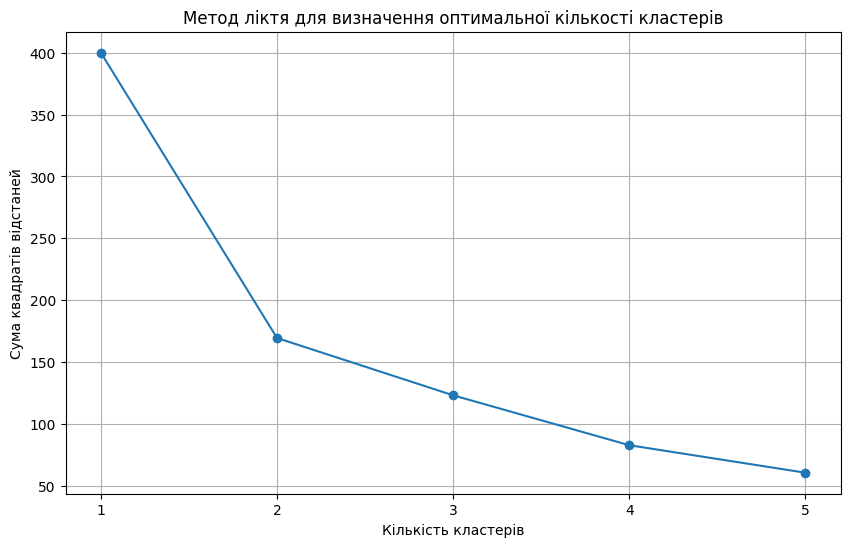

In [ ]:
# Обчислюємо суму квадратів відстаней від кожної точки до її центроїда для різної кількості кластерів
inertia = []
k_range = range(1, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled[['Feature 1', 'Feature 2']])
    inertia.append(kmeans.inertia_)

# Візуалізація методу ліктя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Метод ліктя для визначення оптимальної кількості кластерів')
plt.xlabel('Кількість кластерів')
plt.ylabel('Сума квадратів відстаней')
plt.xticks(k_range)
plt.grid(True)
plt.show()

* Сильне Зменшення Варіативності: Спад суми квадратів відстаней є сильно вираженим при переході від одного кластера до двох. Це вказує на значне зменшення внутрішньокластерної варіативності, коли дані діляться на два кластери.

* Полегшення Спаду: Після двох кластерів спад суми квадратів стає полегшим, що означає, що кожне додаткове збільшення кількості кластерів привносить все менше інформації щодо внутрішньокластерної варіативності.

* Візуальний Лікоть: Хоча візуальний "лікоть" не виражений дуже ясно, можна припустити, що він знаходиться між 2 та 3 кластерами. Це може вказувати на те, що оптимальною кількістю кластерів для цього набору даних може бути 2 або 3.

# Частина 2: Зменшення розмірності
# Огляд датасету та постановка задачі зниження розмірностей

Зменшення розмірності даних — це процес зменшення кількості випадкових змінних, який береться до уваги, шляхом отримання набору головних змінних. Це часто використовується для видалення шуму, поліпшення ефективності алгоритмів машинного навчання, а також для полегшення візуалізації даних. Процес може включати як лінійні методи, такі як головні компоненти аналіз (PCA), так і нелінійні методи, наприклад, вбудовування та маніфолдне навчання.

In [ ]:
# Завантаження датасету
data = load_breast_cancer()

# Виведення опису даних
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
# Створення DataFrame з даними та назвами ознак
df = pd.DataFrame(data.data, columns=data.feature_names)

# Додавання стовпця з цільовими значеннями
df['target'] = data.target

In [ ]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
# Виведення загальної інформації про датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
# Виведення описових статистик для кількісних ознак
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
# Виведення розподілу класів
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [ ]:
# Кореляційний аналіз
df.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


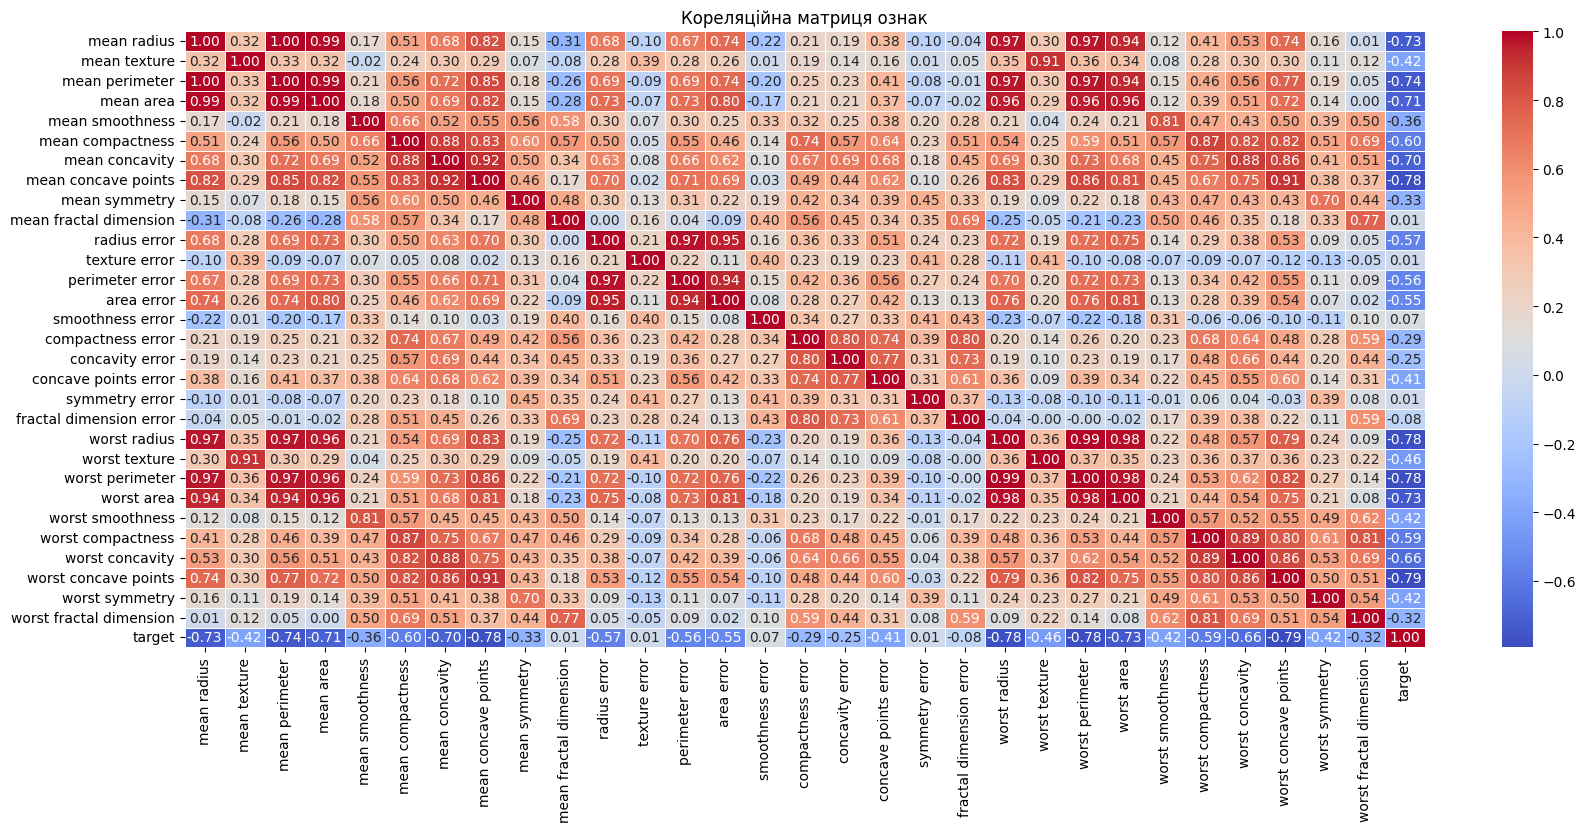

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак')
plt.show()

**Постановка задачі зменшення розмірності даних для датасету Breast Cancer:**

1. **Завдання**:
   Метою є зменшення розмірності даних у датасеті Breast Cancer, зберігаючи при цьому якомога більше важливої інформації.

2. **Дані**:
   - Датасет містить клінічні характеристики клітин, отримані з біопсій молочних залоз.
   - Кількість ознак: 30.
   - Кількість зразків: 569.

3. **Метрика успішності**:
   - Збереження якомога більше важливої інформації після зменшення розмірності.
   - Збереження корисних властивостей для подальшого аналізу та класифікації.
   - Зменшення розмірності даних до оптимального рівня, що дозволяє підтримувати ефективність та точність моделі.

4. **Алгоритми та методи**:
   - Використання різних методів зменшення розмірності, таких як головні компоненти (PCA), лінійне дискримінантне аналіз (LDA), t-distributed Stochastic Neighbor Embedding (t-SNE) та інші.
   - Порівняння різних методів за їхньою здатністю зберігати важливість інформації та зберігати корисні властивості даних.

5. **Використання результатів**:
   - Отримані зменшені дані можуть бути використані для подальшого аналізу та класифікації за допомогою різних алгоритмів машинного навчання, забезпечуючи при цьому кращу обчислювальну ефективність та точність моделі.
   - Зменшені дані можуть також бути використані для візуалізації та вивчення структури та взаємозв'язків між ознаками.

## Стандартний метод аналізу головних компонентів (PCA, Principal component analysis)

Головні компоненти аналіз - це статистичний метод, який перетворює оригінальний набір даних на новий набір некорельованих змінних, званих головними компонентами. Ці компоненти ранжуються так, що перша компонента має найбільшу варіативність, друга - наступну за величиною, і так далі. Метод використовується для зменшення розмірності даних з мінімальною втратою інформації.

In [ ]:
# Стандартизація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('target', axis=1))

# Зменшення розмірності методом PCA
pca = PCA(n_components=2)  # Встановлюємо бажану кількість головних компонент
X_pca = pca.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_pca_2 = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca_2['target'] = df['target']

# Виведення зменшених даних
df_pca_2.head()

,PC1,PC2,target
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0


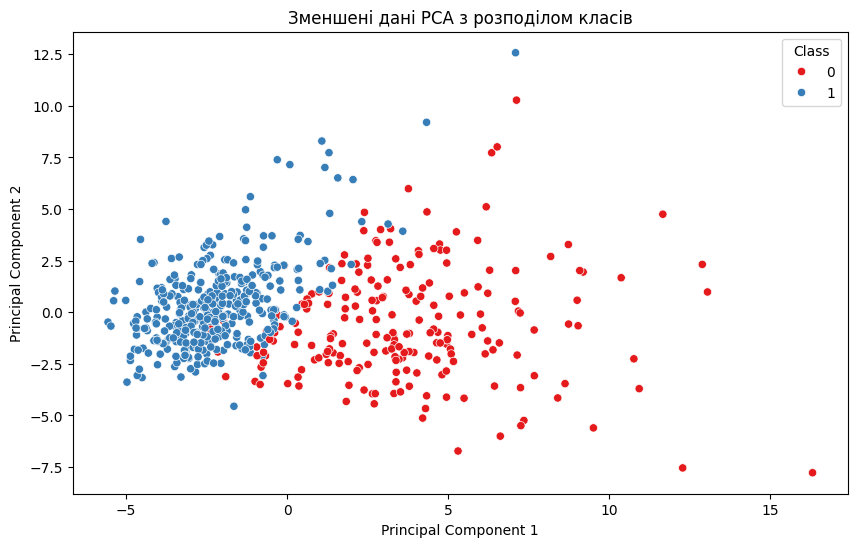

In [ ]:
# Візуалізація зменшених даних
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=df_pca_2, palette='Set1')
plt.title('Зменшені дані PCA з розподілом класів')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', loc='best')
plt.show()

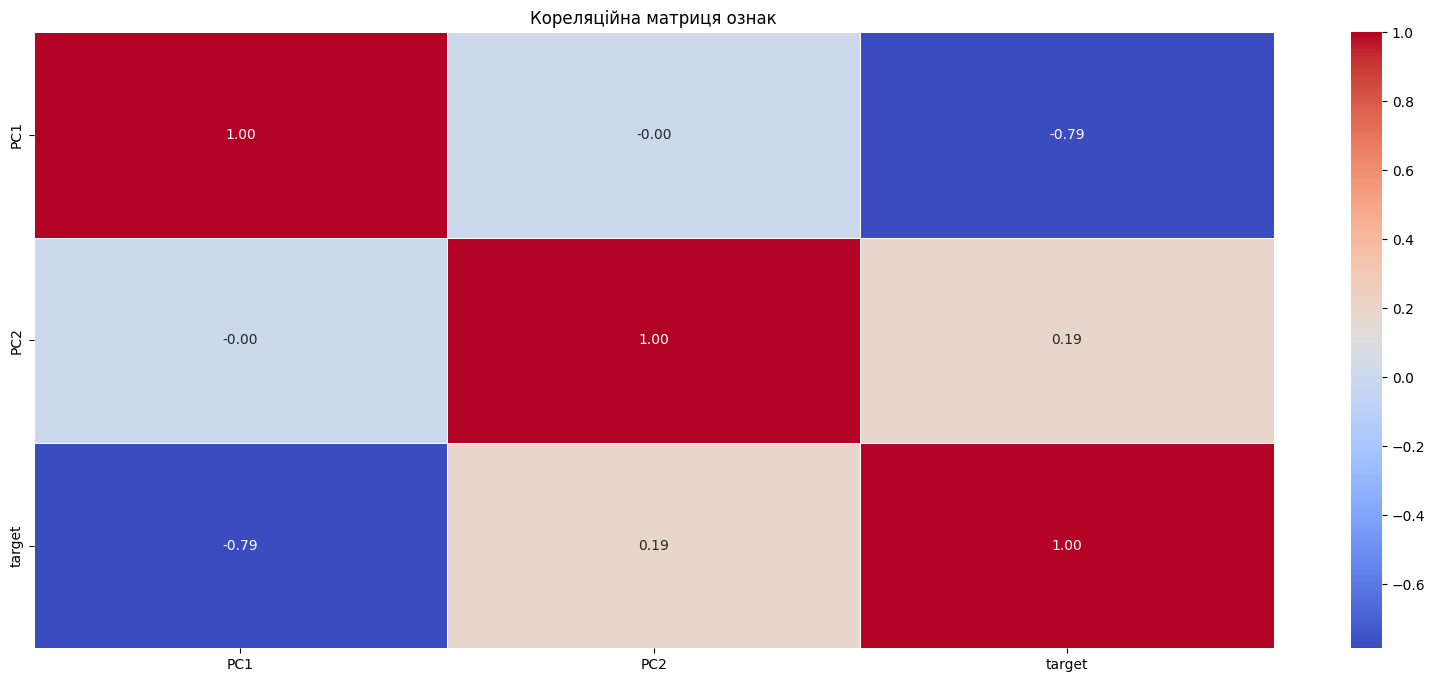

In [ ]:
correlation_matrix = df_pca_2.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак')
plt.show()

In [ ]:
# Зменшення розмірності методом PCA
pca = PCA(n_components=3)  # Встановлюємо бажану кількість головних компонент
X_pca = pca.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_pca_3 = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca_3['target'] = df['target']

# Виведення зменшених даних
df_pca_3.head()

,PC1,PC2,PC3,target
0,9.192837,1.948583,-1.123162,0
1,2.387802,-3.768172,-0.529289,0
2,5.733896,-1.075174,-0.551749,0
3,7.122953,10.275589,-3.232787,0
4,3.935302,-1.948071,1.389769,0


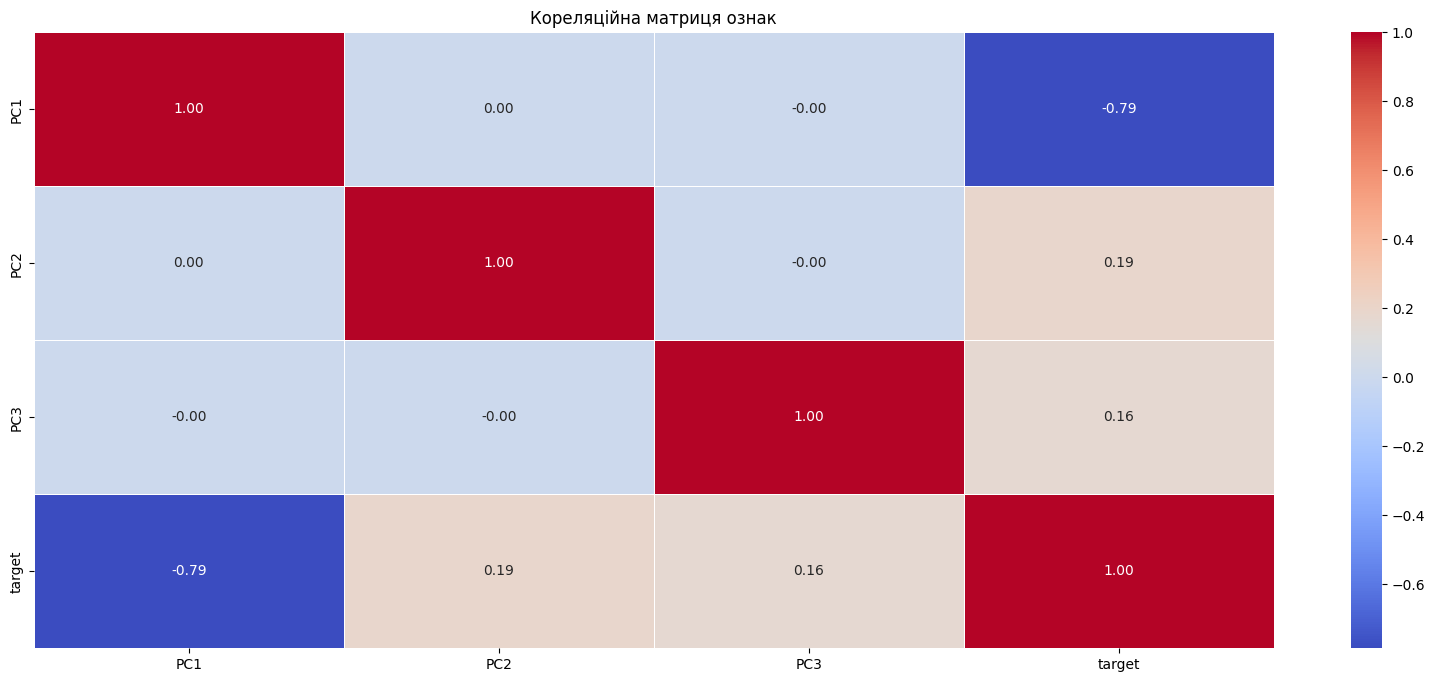

In [ ]:
correlation_matrix = df_pca_3.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак')
plt.show()

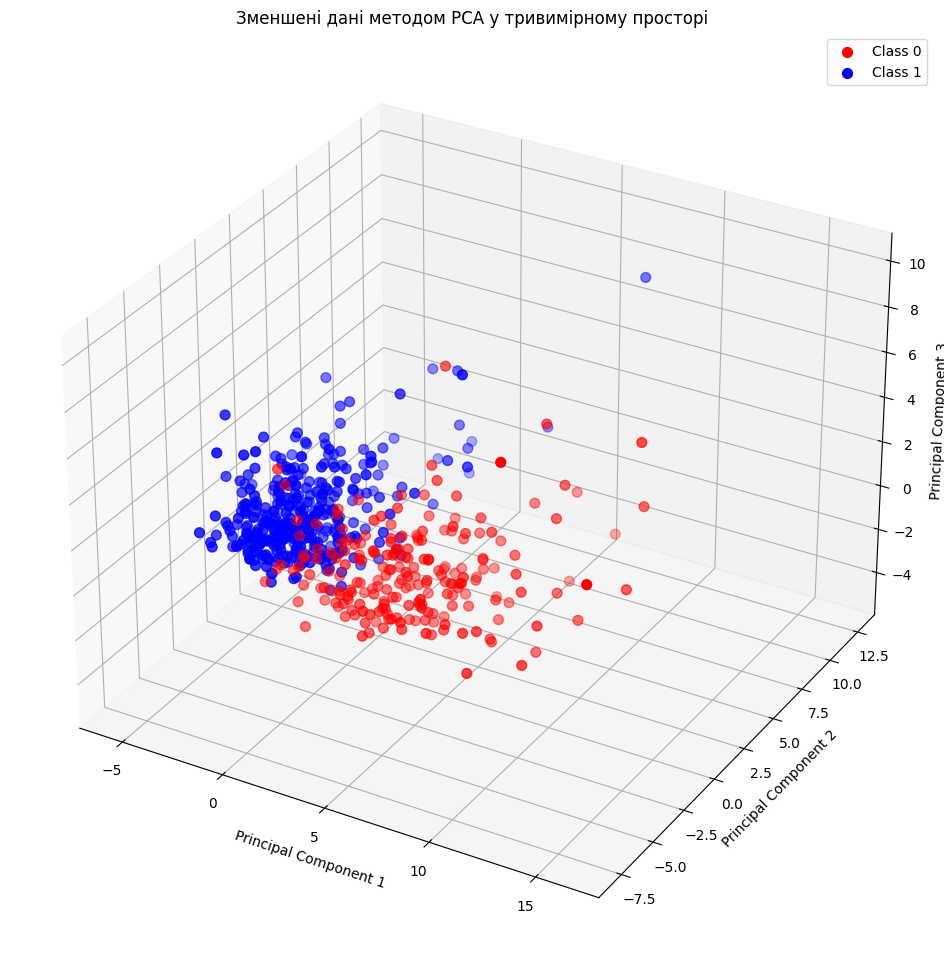

In [ ]:
# Візуалізація зменшених даних
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Розділення даних за класами
targets = [0, 1]  # Припустимо, що ми маємо 2 класи
colors = ['r', 'b']

# Виведення даних для кожного класу
for target, color in zip(targets, colors):
    indices_to_keep = df_pca_3['target'] == target
    ax.scatter(df_pca_3.loc[indices_to_keep, 'PC1'],
               df_pca_3.loc[indices_to_keep, 'PC2'],
               df_pca_3.loc[indices_to_keep, 'PC3'],
               c=color, s=50)

# Підписи осей
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Підписи класів
ax.legend(['Class 0', 'Class 1'])

plt.title('Зменшені дані методом PCA у тривимірному просторі')
plt.show()



На першій матриці:
- `PC1` має високу негативну кореляцію з таргетом (-0.79), що є досить значущим.
- `PC2` і `PC3` мають дуже низьку кореляцію з таргетом (0.19 та 0.16 відповідно).

На другій матриці:
- `PC1` зберігає високу негативну кореляцію з таргетом (-0.79).
- `PC2` має нульову кореляцію з таргетом, а `PC3` не представлений.

Враховуючи ці дані, можна зробити висновок, що в першому випадку `PC1` є значущою компонентою для прогнозування таргету, а `PC2` і `PC3` - ні. Оскільки `PC3` має нульову кореляцію і не присутній в другому випадку, то його можна відкинути. `PC2` також не здається корисною.

Таким чином, виходячи з кореляційних матриць, можна зробити висновок, що одна компонента (`PC1`) є кращою для зменшення розмірності даних в цьому конкретному випадку.

## Ядровий PCA (Kernel PCA)

Розширення PCA, яке використовує ядрові функції для переведення даних у вищий розмірний простір, де лінійне розділення стає можливим. Це дозволяє застосовувати PCA до нелінійних даних, тим самим здатне виділити складніші структури та взаємозв'язки між даними, недоступні при звичайному PCA.

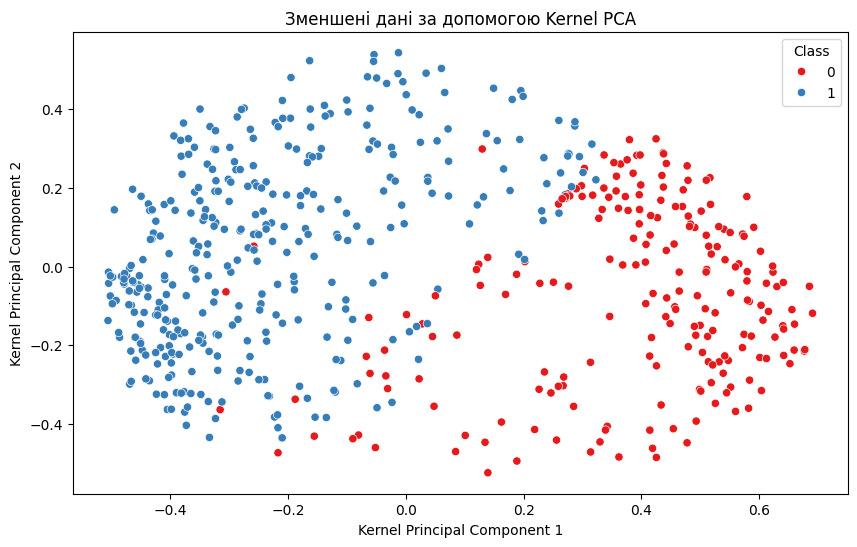

In [ ]:
# Використання Kernel PCA з rbf (Radial Basis Function) ядром
kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_kpca_2 = pd.DataFrame(data=X_kpca, columns=['KPC1', 'KPC2'])
df_kpca_2['target'] = df['target']

# Візуалізація зменшених даних
plt.figure(figsize=(10, 6))
sns.scatterplot(x='KPC1', y='KPC2', hue='target', data=df_kpca_2, palette='Set1')
plt.title('Зменшені дані за допомогою Kernel PCA')
plt.xlabel('Kernel Principal Component 1')
plt.ylabel('Kernel Principal Component 2')
plt.legend(title='Class', loc='best')
plt.show()

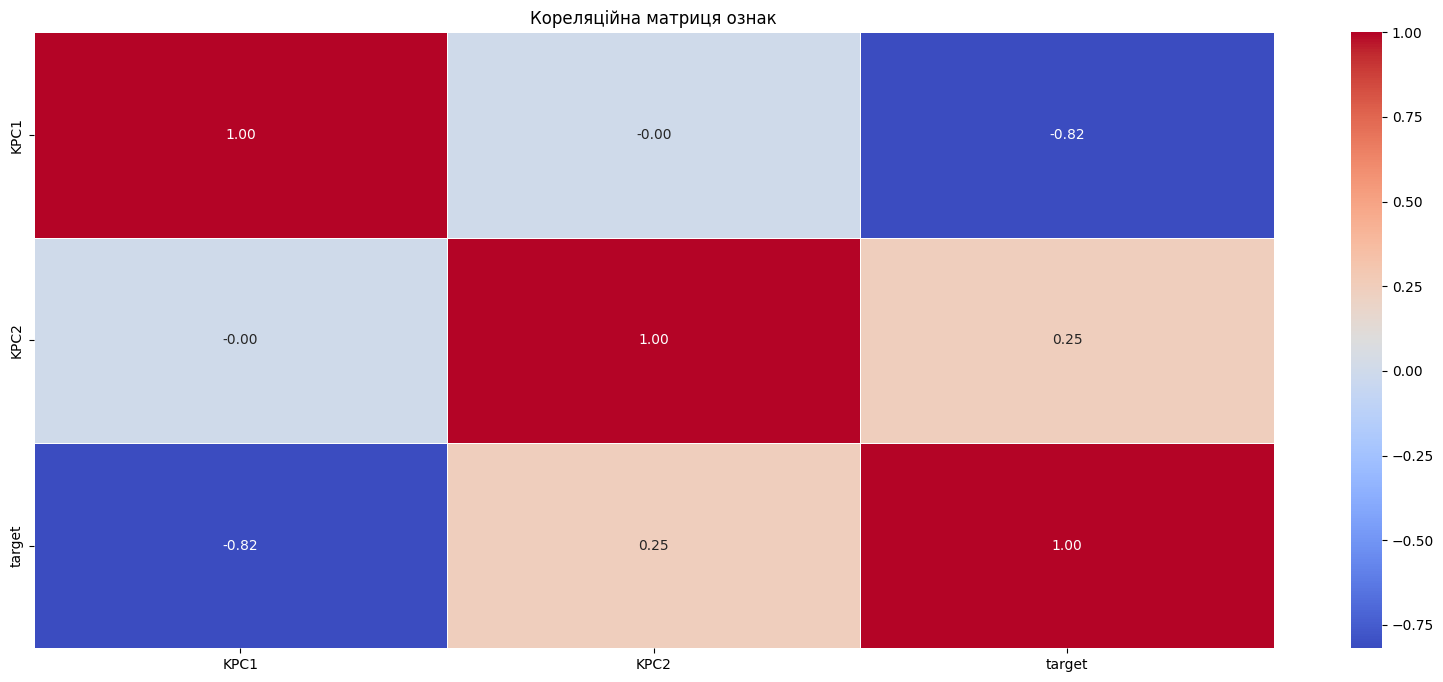

In [ ]:
correlation_matrix = df_kpca_2.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак')
plt.show()

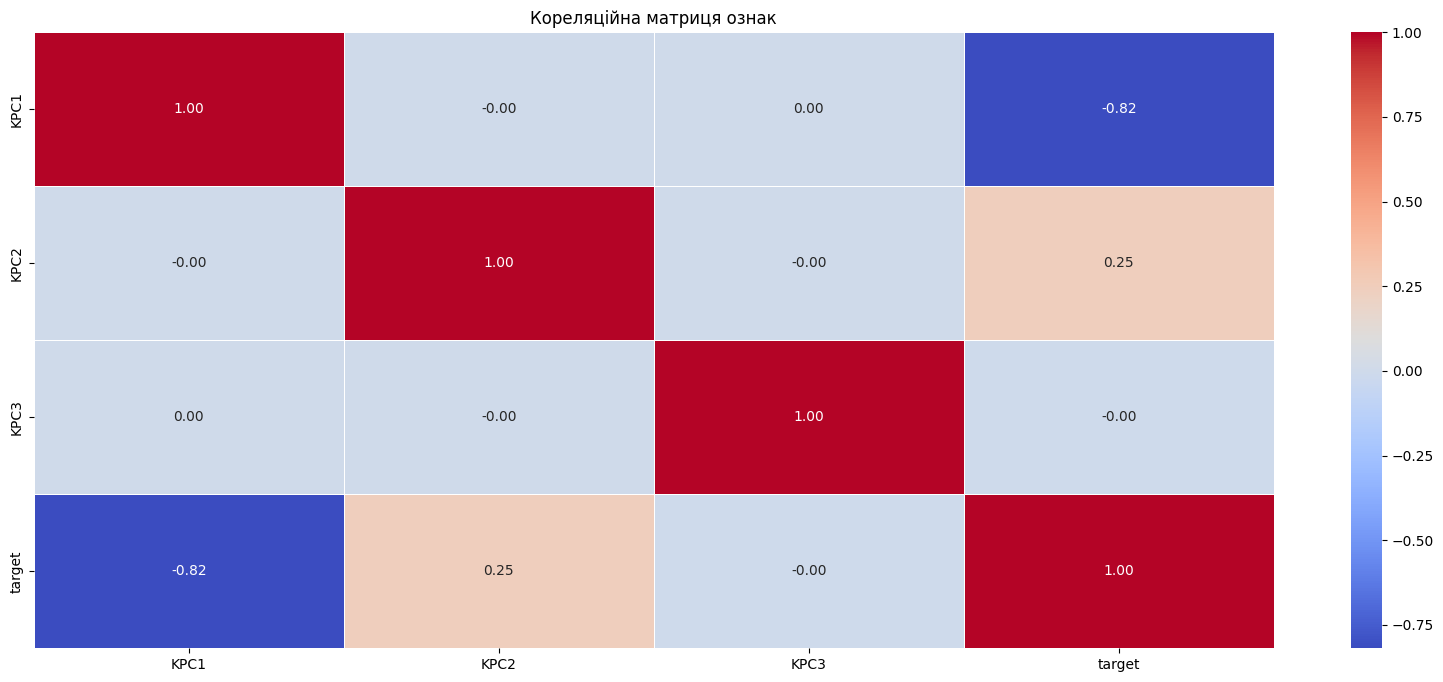

In [ ]:
# Використання Kernel PCA з rbf (Radial Basis Function) ядром
kpca = KernelPCA(n_components=3, kernel='rbf')
X_kpca = kpca.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_kpca_3 = pd.DataFrame(data=X_kpca, columns=['KPC1', 'KPC2', 'KPC3'])
df_kpca_3['target'] = df['target']

correlation_matrix = df_kpca_3.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак')
plt.show()

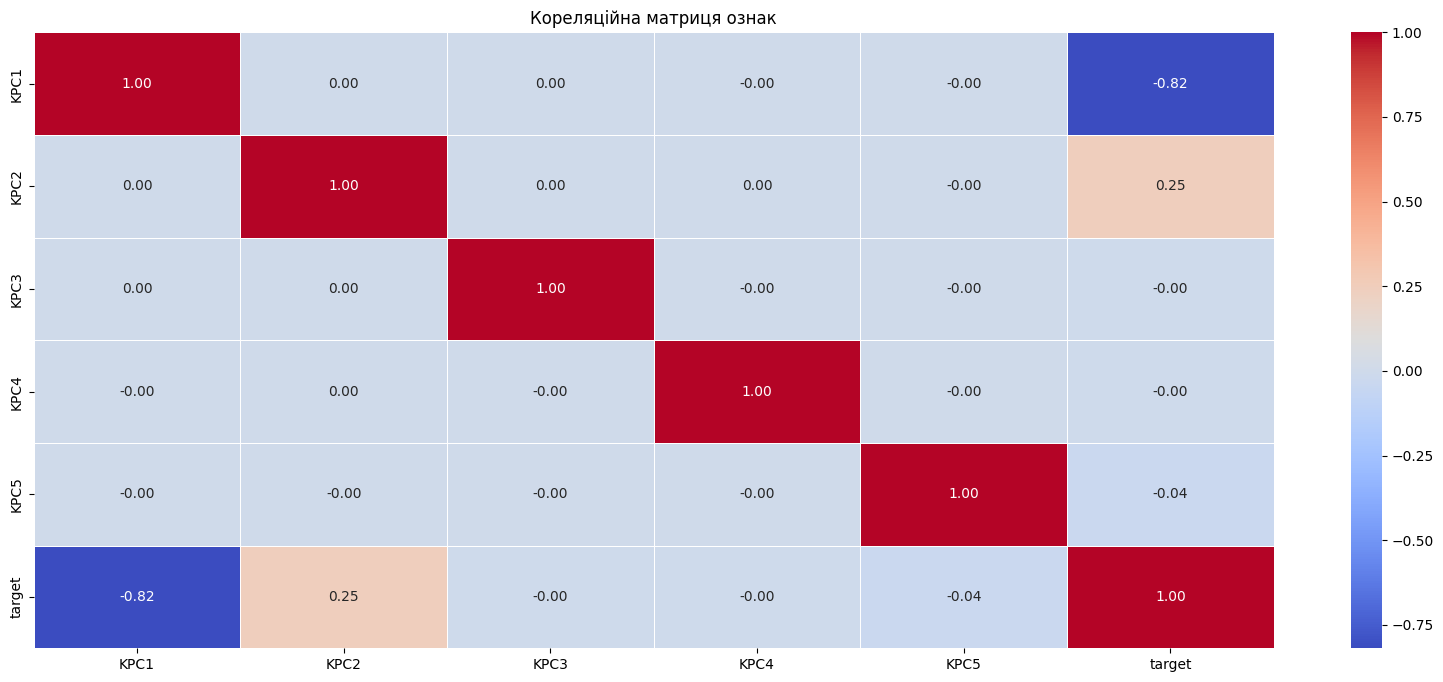

In [ ]:
# Використання Kernel PCA з rbf (Radial Basis Function) ядром
kpca = KernelPCA(n_components=5, kernel='rbf')
X_kpca = kpca.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_kpca_5 = pd.DataFrame(data=X_kpca, columns=['KPC1', 'KPC2', 'KPC3', 'KPC4', 'KPC5'])
df_kpca_5['target'] = df['target']

correlation_matrix = df_kpca_5.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак')
plt.show()

## Ізометричне відображення (Isomap, isometric mapping)

Нелінійний метод зменшення розмірності, що має на меті зберегти геодезичну відстань (тобто приблизну "поверхневу" відстань) між всіма парами точок в оригінальному просторі. Isomap спочатку створює мережу найближчих сусідів, а потім використовує алгоритми найкоротшого шляху, такі як алгоритм Дейкстри або Флойда-Воршелла, для визначення геодезичних відстаней між усіма парами точок, і врешті-решт застосовує метод подібний до PCA для виявлення найважливіших вимірів у цих відстанях. Isomap ефективно розкриває внутрішню геометрію даних, забезпечуючи більш інтуїтивно зрозумілі представлення складних наборів даних.

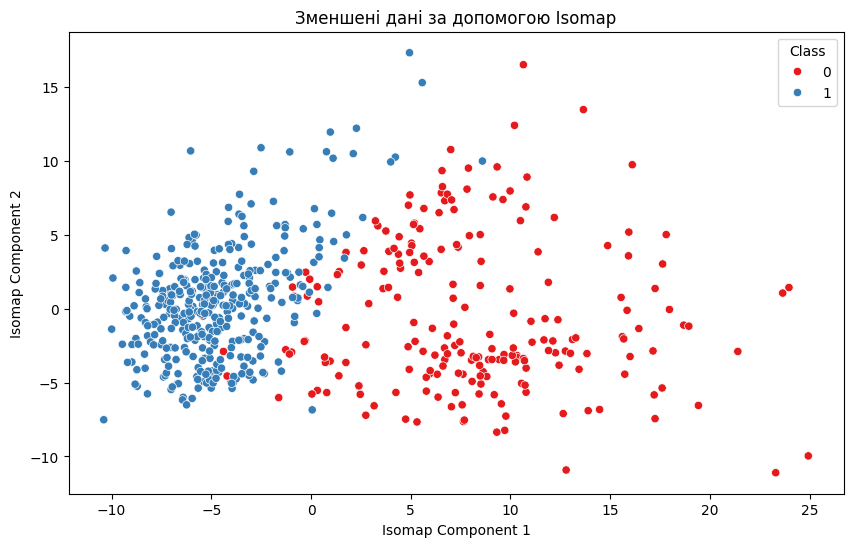

In [ ]:
# Застосування Isomap для зменшення розмірності
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_isomap_2 = pd.DataFrame(data=X_isomap, columns=['Component 1', 'Component 2'])
df_isomap_2['target'] = df['target']

# Візуалізація зменшених даних
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Component 1', y='Component 2', hue='target', data=df_isomap_2, palette='Set1')
plt.title('Зменшені дані за допомогою Isomap')
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')
plt.legend(title='Class', loc='best')
plt.show()

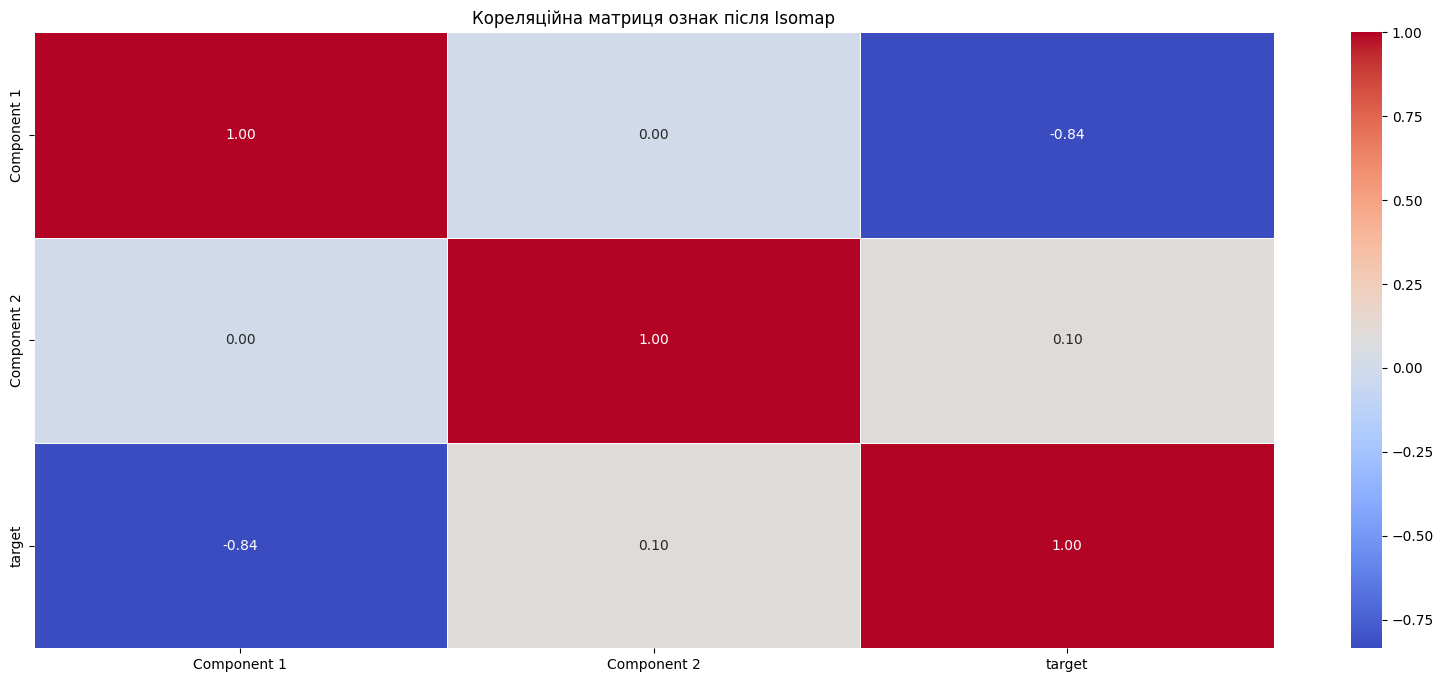

In [ ]:
# Аналіз кореляції між зменшеними ознаками
correlation_matrix = df_isomap_2.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак після Isomap')
plt.show()

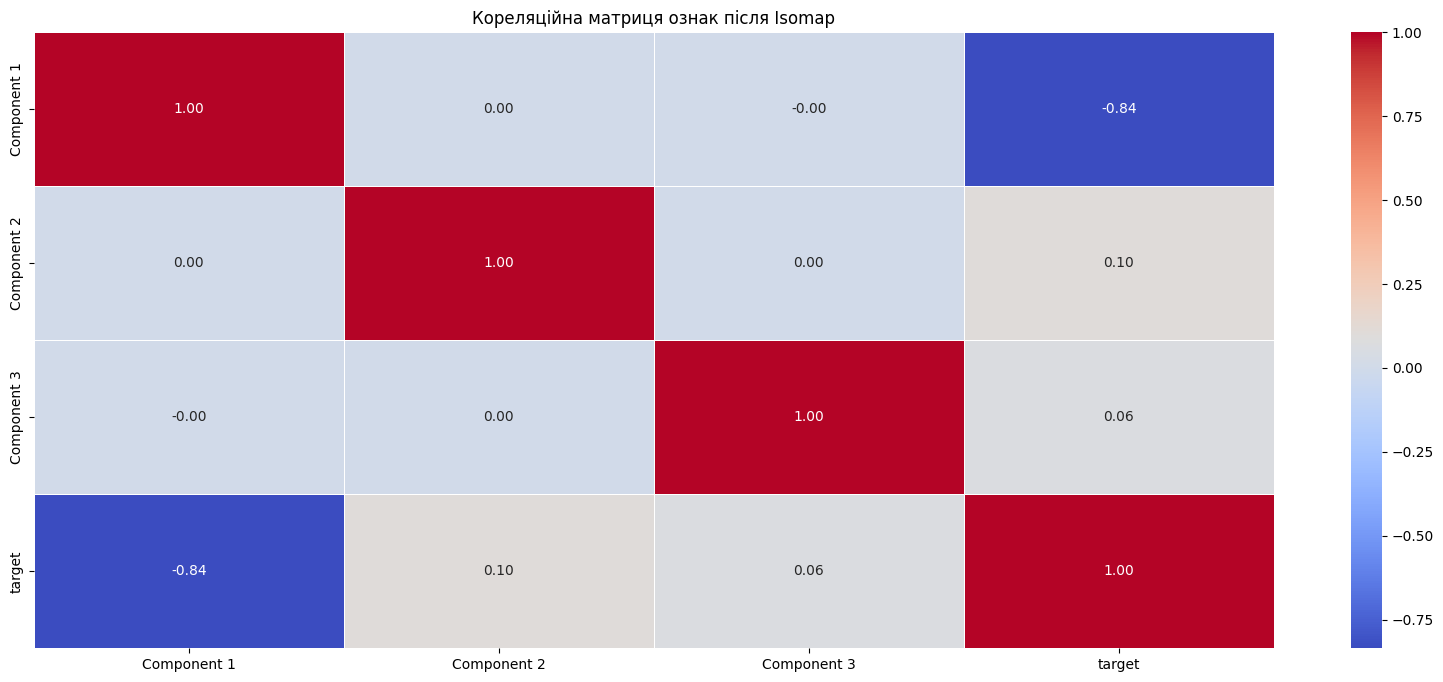

In [ ]:
# Застосування Isomap для зменшення розмірності
isomap = Isomap(n_components=3)
X_isomap = isomap.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_isomap_3 = pd.DataFrame(data=X_isomap, columns=['Component 1', 'Component 2', 'Component 3'])
df_isomap_3['target'] = df['target']

# Аналіз кореляції між зменшеними ознаками
correlation_matrix = df_isomap_3.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак після Isomap')
plt.show()

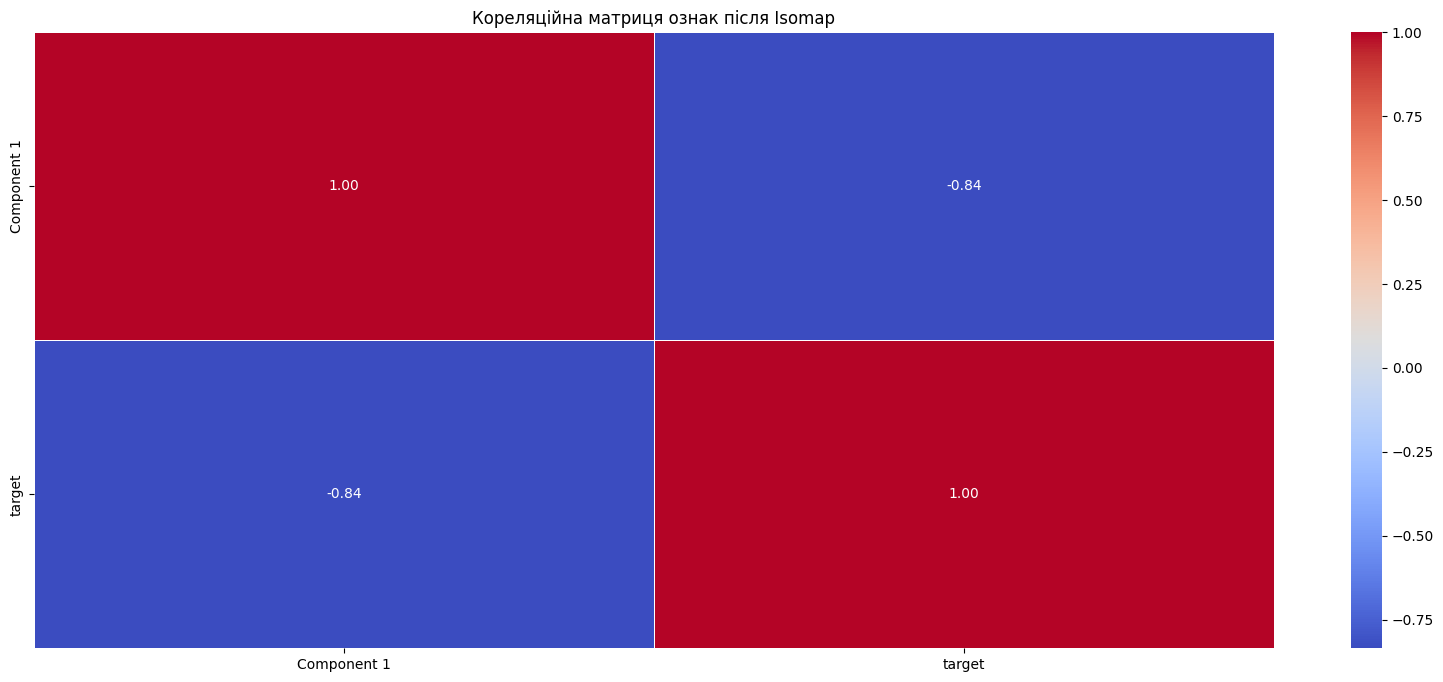

In [ ]:
# Застосування Isomap для зменшення розмірності
isomap = Isomap(n_components=1)
X_isomap = isomap.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_isomap_1 = pd.DataFrame(data=X_isomap, columns=['Component 1'])
df_isomap_1['target'] = df['target']

# Аналіз кореляції між зменшеними ознаками
correlation_matrix = df_isomap_1.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак після Isomap')
plt.show()

Цільова змінна target має високу негативну кореляцію (-0.84) з першим компонентом, що вказує на те, що зі збільшенням значення першого компоненту, вірогідність належності до конкретного класу, позначеного target, знижується.

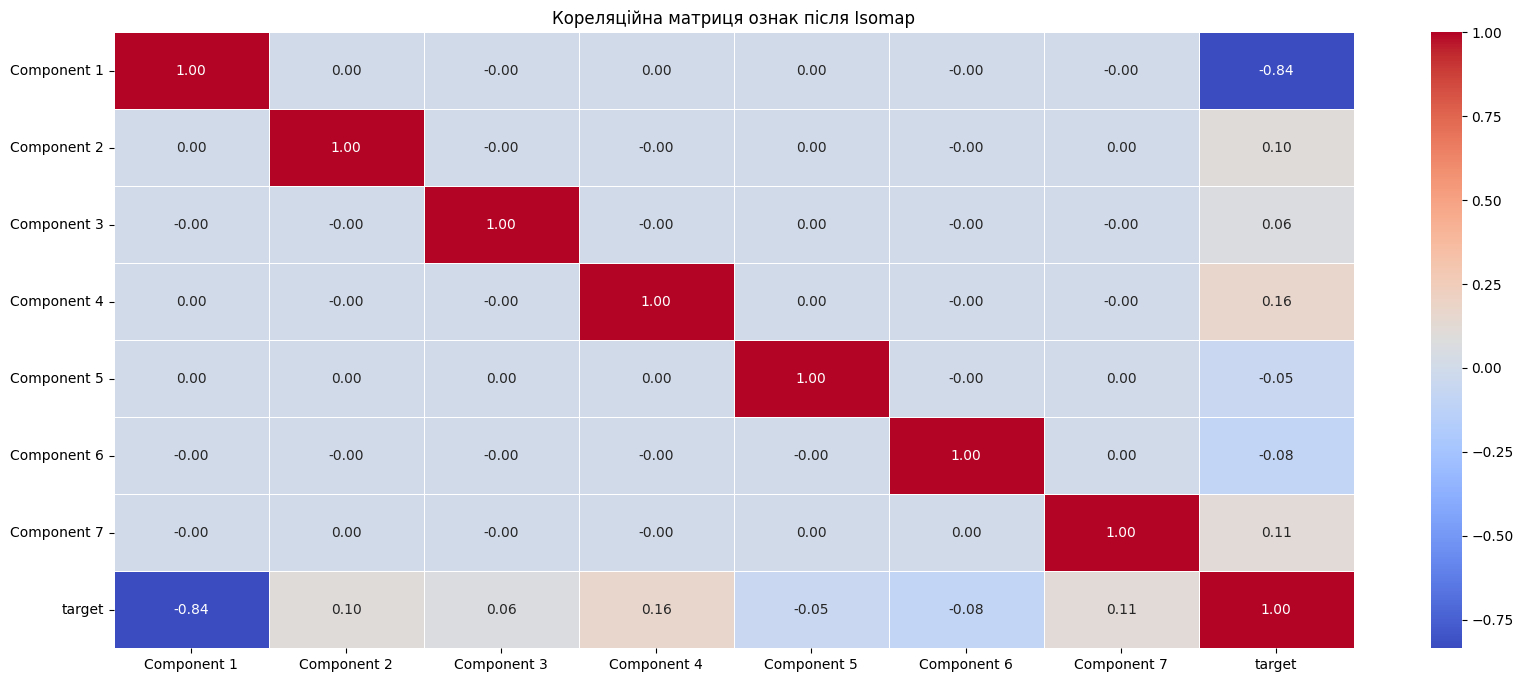

In [ ]:
# Застосування Isomap для зменшення розмірності
isomap = Isomap(n_components=7)
X_isomap = isomap.fit_transform(X_scaled)

# Створення DataFrame зі зменшеними даними
df_isomap_7 = pd.DataFrame(data=X_isomap, columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7'])
df_isomap_7['target'] = df['target']

# Аналіз кореляції між зменшеними ознаками
correlation_matrix = df_isomap_7.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця ознак після Isomap')
plt.show()

З цієї матриці ми можемо зробити кілька спостережень:
- Компоненти від 1 до 7 мають дуже низьку або відсутню кореляцію між собою, що свідчить про те, що вони представляють різні аспекти даних, як це й очікується після зменшення розмірності методом Isomap.
- Цільова змінна `target` має найвищу кореляцію з компонентом 1 (-0.84), що вказує на значний зв'язок між цим компонентом і міткою класу. Це може означати, що перший компонент є значимим для прогнозування `target`.
- Інші компоненти показують дуже низьку кореляцію з цільовою змінною, це означає, що вони менш важливі для прогнозування цільової змінної.
- Компоненти 3, 4 та 7 мають дуже слабку позитивну кореляцію з `target`, тоді як компоненти 5 і 6 мають слабку негативну кореляцію.

На підставі цих даних можна зробити висновок, що розподіл даних на 7 компонентів дає деталізоване розуміння взаємозв'язків у даних, але не всі компоненти мають високу інформативність щодо цільової змінної. Це може бути корисним, якщо метою є виявлення складних не лінійних взаємозв'язків у даних, але для простіших завдань або коли потрібно врахувати обчислювальні обмеження, можна розглянути використання меншої кількості компонентів.

# Висновки: Визначення мінімально необіхдної кількості компонент

На основі результатів аналізу зменшення розмірності даних за допомогою трьох методів (PCA, Ядровий PCA, і Isomap), де було розглянуто від 1 до 7 компонент, можна зробити наступні висновки:

1. **Першорядне значення першої компоненти**: Отримана висока негативна кореляція (-0.84) першої компоненти з таргетом свідчить про значну інформативність цієї компоненти у контексті передбачуваної змінної. Це підкреслює важливість першої компоненти як основного внеску у варіативність даних і її здатність пояснювати велику частину інформації, що має відношення до таргету.

2. **Обмежена кореляція інших компонент**: Незначна кореляція інших компонент, від другої до сьомої, з таргетом і між собою може вказувати на те, що більшість інформації, корисної для прогнозування таргету, зосереджена в першій компоненті. Це також може свідчити про низьку внутрішню розмірність оригінального датасету щодо цілі прогнозування.

3. **Мінімальна необхідна кількість компонент**: З урахуванням цих результатів, мінімально необхідною кількістю компонент для ефективного зменшення розмірності, не втрачаючи при цьому важливої інформації для прогнозування таргету, може бути одна компонента. Однак, це не виключає можливості того, що інші компоненти можуть містити корисну інформацію для інших видів аналізу або для покращення моделей машинного навчання з додатковими регуляризаційними обмеженнями.